# NLP Modeling

## Import necessary libraries for modeling

In [264]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

## Create function to evaluate models

In [268]:
def evaluator(X_train, y_train, X_test, y_test, model):
    start = time.time()
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    end = time.time()
    print("Model Time: {}".format(end-start))
    print("Training:{}".format(classification_report(y_train, train_preds)))
    print("Testing:{}".format(classification_report(y_test, test_preds)))
    
    print('Mean Absolute Error:', mean_absolute_error(y_test, test_preds))  
    print('Mean Squared Error:', mean_squared_error(y_test, test_preds))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_preds)))
    
    
    model_confusion_matrix = plot_confusion_matrix(model, X_test, y_test)

In [269]:
## import cleaned data
df = pd.read_csv('Cleaned_data.csv')

In [270]:
df.head()

,tweet,emotion
0,wesley83 3g iphone 3 hr tweeting rise_austin d...,0
1,jessedee know fludapp awesome ipad/iphone app ...,1
2,swonderlin wait ipad 2 also sale sxsw,1
3,sxsw hope year festival crashy year iphone app...,0
4,sxtxstate great stuff fri sxsw marissa mayer g...,1


In [271]:
## assign X and y variables
X = df.tweet
y = df.emotion

# Baseline Model

In [272]:
## Perform train test split and initialize tfidf for baseline model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

tfidf = TfidfVectorizer()

tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

tfidf_data_train

<2838x4948 sparse matrix of type '<class 'numpy.float64'>'
	with 33327 stored elements in Compressed Sparse Row format>

In [273]:
## Create baseline model
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

Model Time: 0.8967099189758301
Training:              precision    recall  f1-score   support

           0       1.00      1.00      1.00       449
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      2838
   macro avg       1.00      1.00      1.00      2838
weighted avg       1.00      1.00      1.00      2838

Testing:              precision    recall  f1-score   support

           0       0.93      0.22      0.36       121
           1       0.86      1.00      0.92       589

    accuracy                           0.86       710
   macro avg       0.90      0.61      0.64       710
weighted avg       0.87      0.86      0.83       710

Mean Absolute Error: 0.1352112676056338
Mean Squared Error: 0.1352112676056338
Root Mean Squared Error: 0.36771084782153735


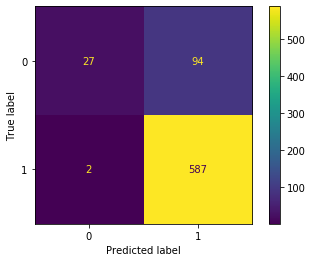

In [274]:
## evaluate baseline model 
evaluator(tfidf_data_train, y_train, tfidf_data_test, y_test, rf_classifier)

The model has overfitting and very low recall for tweets with a negative emotion

# Iterative Modeling Process

In [172]:
## I will use SMOTE to deal with class imbalance and begin tuning the model with gridsearch
from imblearn.pipeline import Pipeline
pipeline = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('smt', SMOTE()),
                    ('RF', RandomForestClassifier())])


In [25]:
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5],
        'tfidf__max_df': np.linspace(0.1, 1, 10),
        'tfidf__binary': [True, False],
      'tfidf__norm': [None, 'l1', 'l2']}]

In [33]:
gridsearch = GridSearchCV(estimator=pipeline, 
                          param_grid=grid, 
                          scoring='f1', 
                          cv=5)

Model Time: 1563.372566461563
Training Classifiction Report:               precision    recall  f1-score   support

           0       0.97      0.08      0.16       449
           1       0.85      1.00      0.92      2389

    accuracy                           0.85      2838
   macro avg       0.91      0.54      0.54      2838
weighted avg       0.87      0.85      0.80      2838

Testing Classifiction Report:               precision    recall  f1-score   support

           0       1.00      0.03      0.06       121
           1       0.83      1.00      0.91       589

    accuracy                           0.84       710
   macro avg       0.92      0.52      0.49       710
weighted avg       0.86      0.84      0.77       710

Mean Absolute Error: 0.1647887323943662
Mean Squared Error: 0.1647887323943662
Root Mean Squared Error: 0.40594178448931095


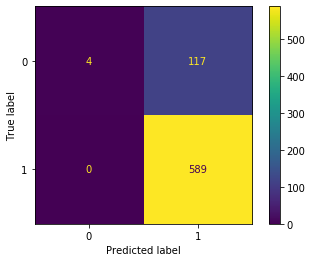

In [34]:
evaluator(X_train, y_train, X_test, y_test, df, y, gridsearch)

This initial gridsearch random forrest model predicts positive emotion perfectly but predicts the negative emotion very poorly. 

Lets try a Multinomial Naive Bayes model next. 

In [173]:
pipeline2 = Pipeline([
                    ('tfidf', TfidfVectorizer()),
                    ('smt', SMOTE()),
                    ('NB', MultinomialNB())])

In [177]:
grid2 = {'NB__alpha': np.linspace(0.5, 1.5, 6),
  'NB__fit_prior': [True, False],
  'tfidf__max_df': np.linspace(0.1, 1, 10),
  'tfidf__binary': [True, False],
  'tfidf__norm': [None, 'l1', 'l2'],
    'tfidf__ngram_range':[(1,1),(1,2),(2,2)],
    'tfidf__max_features':[None, 1000, 2000]}

In [178]:
gridsearch2 = GridSearchCV(estimator=pipeline2, 
                          param_grid=grid2, 
                          scoring='accuracy', 
                          cv=5)

Model Time: 2886.7257101535797
Training:               precision    recall  f1-score   support

           0       0.98      0.99      0.98       449
           1       1.00      1.00      1.00      2389

    accuracy                           1.00      2838
   macro avg       0.99      0.99      0.99      2838
weighted avg       1.00      1.00      1.00      2838

Testing:               precision    recall  f1-score   support

           0       0.62      0.48      0.54       121
           1       0.90      0.94      0.92       589

    accuracy                           0.86       710
   macro avg       0.76      0.71      0.73       710
weighted avg       0.85      0.86      0.85       710

Mean Absolute Error: 0.13943661971830987
Mean Squared Error: 0.13943661971830987
Root Mean Squared Error: 0.3734121311879274


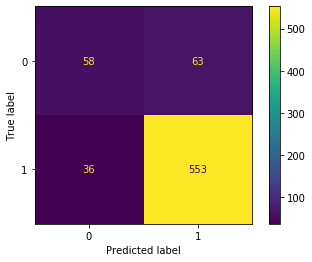

In [179]:
evaluator(X_train, y_train, X_test, y_test, df, y, gridsearch2)

In [180]:
gridsearch2.best_params_

{'NB__alpha': 0.7,
 'NB__fit_prior': False,
 'tfidf__binary': False,
 'tfidf__max_df': 0.2,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': None}

In [283]:
FinalNB = Pipeline([
                    ('tfidf', TfidfVectorizer(binary = False,
                                            max_df = 0.2,
                                             max_features = None,
                                            ngram_range = (1, 2),
                                             norm = None)),
                    ('smt', SMOTE()),
                    ('NB', MultinomialNB(alpha = .7, 
                                        fit_prior = False))])

Model Time: 0.17304468154907227
Training:              precision    recall  f1-score   support

           0       0.97      1.00      0.98       449
           1       1.00      0.99      1.00      2389

    accuracy                           1.00      2838
   macro avg       0.99      1.00      0.99      2838
weighted avg       1.00      1.00      1.00      2838

Testing:              precision    recall  f1-score   support

           0       0.63      0.48      0.54       121
           1       0.90      0.94      0.92       589

    accuracy                           0.86       710
   macro avg       0.76      0.71      0.73       710
weighted avg       0.85      0.86      0.86       710

Mean Absolute Error: 0.13661971830985917
Mean Squared Error: 0.13661971830985917
Root Mean Squared Error: 0.3696210468978453


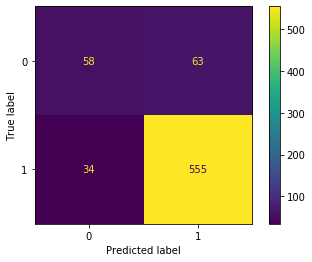

In [284]:
evaluator(X_train, y_train, X_test, y_test, FinalNB)

This final Naive Bayes model has the best ratio between correct positive emotion predictions and negative emotion predictions and recall score. However, it may suffer from overfitting.

Now I will attempt to tune a better Random Forest model using bigrams.

In [39]:
pipeline3 = Pipeline([
                    ('tfidf', TfidfVectorizer(ngram_range=(2,2))),
                    ('smt', SMOTE()),
                    ('RF', RandomForestClassifier())])

In [40]:
grid3 = {'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5],
        'tfidf__max_df': np.linspace(0.1, 1, 10),
          'tfidf__binary': [True, False],
          'tfidf__norm': [None, 'l1', 'l2']}

In [41]:
gridsearch3 = GridSearchCV(estimator=pipeline3, 
                          param_grid=grid3, 
                          scoring='accuracy', 
                          cv=5)

Model Time: 1783.2551505565643
Training Classifiction Report:               precision    recall  f1-score   support

           0       0.94      0.15      0.25       449
           1       0.86      1.00      0.92      2389

    accuracy                           0.86      2838
   macro avg       0.90      0.57      0.59      2838
weighted avg       0.87      0.86      0.82      2838

Testing Classifiction Report:               precision    recall  f1-score   support

           0       1.00      0.04      0.08       121
           1       0.84      1.00      0.91       589

    accuracy                           0.84       710
   macro avg       0.92      0.52      0.49       710
weighted avg       0.86      0.84      0.77       710

Mean Absolute Error: 0.16338028169014085
Mean Squared Error: 0.16338028169014085
Root Mean Squared Error: 0.40420326778755866


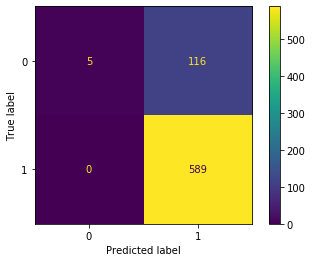

In [42]:
evaluator(X_train, y_train, X_test, y_test, gridsearch3)

In [92]:
## perhaps a decision tree might be better
pipeline4 = Pipeline([
                    ('tfidf', TfidfVectorizer(ngram_range=(2,2))),
                    ('smt', SMOTE()),
                    ('DT', DecisionTreeClassifier())])

In [93]:
grid4 = {'DT__criterion': ['gini', 'entropy'],
    'DT__max_depth': [None, 5, 10, 15,],
    'DT__min_samples_split': [2, 5, 10],
    'DT__min_samples_leaf': [2,5,10],
      'tfidf__max_df': np.linspace(0.1, 1, 10),
          'tfidf__binary': [True, False],
          'tfidf__norm': [None, 'l1', 'l2'],}

In [94]:
gridsearch4 = GridSearchCV(estimator=pipeline4, 
                          param_grid=grid4, 
                          scoring='accuracy', 
                          cv=5)

Model Time: 3416.3249640464783
Training Classifiction Report:               precision    recall  f1-score   support

           0       0.91      0.14      0.24       449
           1       0.86      1.00      0.92      2389

    accuracy                           0.86      2838
   macro avg       0.89      0.57      0.58      2838
weighted avg       0.87      0.86      0.81      2838

Testing Classifiction Report:               precision    recall  f1-score   support

           0       0.79      0.09      0.16       121
           1       0.84      0.99      0.91       589

    accuracy                           0.84       710
   macro avg       0.81      0.54      0.54       710
weighted avg       0.83      0.84      0.78       710

Mean Absolute Error: 0.1591549295774648
Mean Squared Error: 0.1591549295774648
Root Mean Squared Error: 0.39894226346360545


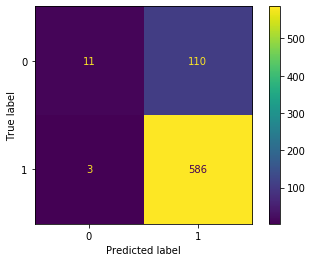

In [95]:
evaluator(X_train, y_train, X_test, y_test, gridsearch4)

Using the information learned from the previous models I decided to manually change certain params to find the best random forest model.   

In [280]:

pipeline5 = Pipeline([
                    ('tfidf', TfidfVectorizer(binary =False,
                     max_df =.7,
                     ngram_range = (1,2),
                    max_features = 2200)),
                    ('smt', SMOTE()),
                    ('RF', RandomForestClassifier(
                        max_depth = 6,
                        min_samples_leaf = 3,
                        min_samples_split =5))])

Model Time: 0.38297486305236816
Training:              precision    recall  f1-score   support

           0       0.46      0.56      0.50       449
           1       0.91      0.88      0.89      2389

    accuracy                           0.83      2838
   macro avg       0.69      0.72      0.70      2838
weighted avg       0.84      0.83      0.83      2838

Testing:              precision    recall  f1-score   support

           0       0.36      0.36      0.36       121
           1       0.87      0.87      0.87       589

    accuracy                           0.78       710
   macro avg       0.62      0.61      0.62       710
weighted avg       0.78      0.78      0.78       710

Mean Absolute Error: 0.21549295774647886
Mean Squared Error: 0.21549295774647886
Root Mean Squared Error: 0.4642121904328654


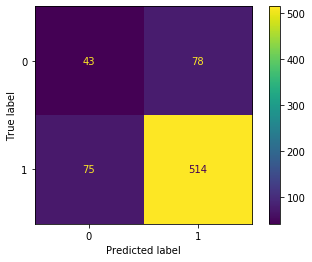

In [282]:
evaluator(X_train, y_train, X_test, y_test,pipeline5)

The final tfidf params I decided to use include bigrams, as well as single words, and a max features of 1500. There was a required trade off between positive emotion recall and negative emotion recall. 

In [290]:
FinalRF = Pipeline([('tfidf', TfidfVectorizer(binary = False,
                            max_df =0.7,
                            ngram_range = (1,2),
                            max_features = 1500)),
                    ('smt', SMOTE()),
                    ('RF', RandomForestClassifier(
                        max_depth = 6,
                        min_samples_leaf = 3,
                        min_samples_split = 5))])

Model Time: 0.3720052242279053
Training:              precision    recall  f1-score   support

           0       0.45      0.61      0.52       449
           1       0.92      0.86      0.89      2389

    accuracy                           0.82      2838
   macro avg       0.69      0.73      0.71      2838
weighted avg       0.85      0.82      0.83      2838

Testing:              precision    recall  f1-score   support

           0       0.36      0.44      0.39       121
           1       0.88      0.84      0.86       589

    accuracy                           0.77       710
   macro avg       0.62      0.64      0.63       710
weighted avg       0.79      0.77      0.78       710

Mean Absolute Error: 0.2295774647887324
Mean Squared Error: 0.2295774647887324
Root Mean Squared Error: 0.47914242641278637


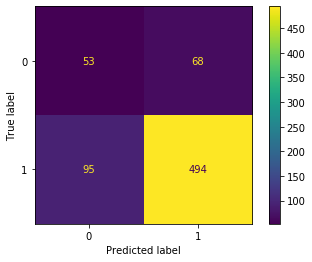

In [291]:
evaluator(X_train, y_train, X_test, y_test, FinalRF)

In [292]:
from sklearn.feature_extraction.text import TfidfVectorizer
names = FinalRF['tfidf'].get_feature_names()
coef = FinalRF['RF'].feature_importances_

In [293]:
zipped = zip(names, coef)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

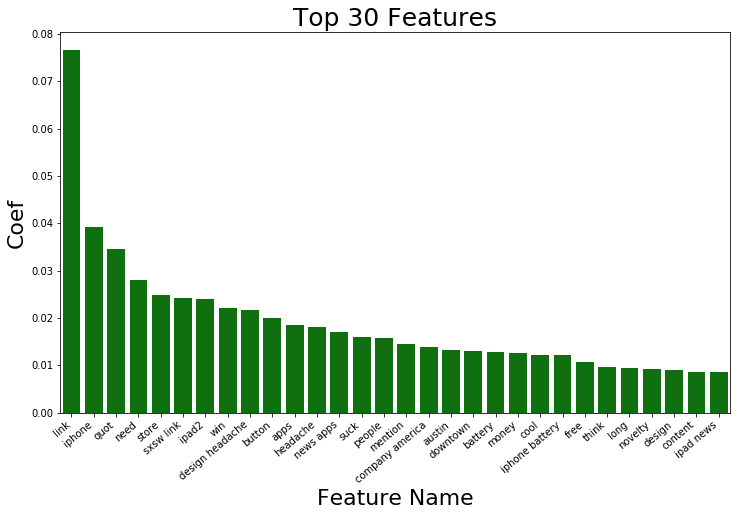

In [296]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(30),
           palette=df.head(30)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40,ha="right", fontsize=10)
ax.set_title("Top 30 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

# Conclusion

A model can be developed to categorize the emotion of a tweet. 
Some words used to categorize the tweet were:
‘Design headache’
‘Suck’
‘Cool’
‘Win’
‘Need’
More data is needed to better categorize the emotions, especially in the negative emotion category.
A trade off between positive emotion recall and negative emotion recall was required.  
Using bigrams, pairs of words, may help to provide context to improve the model. 
